#### 1.0 Importing Dependencies:

In [1]:
# Importing dependencies:
import pandas as pd
import numpy as np
from scipy import stats

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

# Set custom preferences for displaying and visualizing data
# sns.set_style('white')
pd.set_option('max_colwidth', 120)
pd.set_option('max_columns', 200)
pd.set_option('precision', 2)
plt.rcParams["figure.figsize"] = (10, 7.5)

%matplotlib inline

#### 2.0 Applied Machine Leaning:

In [2]:
df = pd.read_csv('data/clean_demographic_transaction.csv')
df.head()

//anaconda3/envs/Springboard/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,household_key,basket_id,day,product_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc,customer_price,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
0,1364,26984896261,1,842930,1,2.19,31742,0.00,1520,1,0.0,0.0,2.19,65+,B,100-124K,Homeowner,Single Female,1,None/Unknown
1,1364,26984896261,1,897044,1,2.99,31742,-0.40,1520,1,0.0,0.0,2.99,65+,B,100-124K,Homeowner,Single Female,1,None/Unknown
2,1364,26984896261,1,920955,1,3.09,31742,0.00,1520,1,0.0,0.0,3.09,65+,B,100-124K,Homeowner,Single Female,1,None/Unknown
3,1364,26984896261,1,937406,1,2.50,31742,-0.99,1520,1,0.0,0.0,2.50,65+,B,100-124K,Homeowner,Single Female,1,None/Unknown
4,1364,26984896261,1,981760,1,0.60,31742,-0.79,1520,1,0.0,0.0,0.60,65+,B,100-124K,Homeowner,Single Female,1,None/Unknown


In [13]:
top_10 = df['product_id'].value_counts().index
top_10 = top_10[:15]
top_10

Int64Index([1082185, 6534178, 1029743,  995242,  981760, 1106523, 1133018,
             951590, 1127831,  883404,  961554,  860776,  840361,  995785,
             826249],
           dtype='int64')

In [14]:
# transaction_df_clean.loc[transaction_df_clean['customer_price'] < 0, 'customer_price'] = 0
df_ml = df.loc[df['product_id'].isin(top_10)]
df_ml = df_ml.groupby(['household_key', 'product_id']).size().reset_index(name='count')
df_ml.head()

,household_key,product_id,count
0,1,840361,14
1,1,860776,1
2,1,961554,8
3,1,995242,35
4,1,995785,1


In [15]:
df_ml.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7744 entries, 0 to 7743
Data columns (total 3 columns):
household_key    7744 non-null int64
product_id       7744 non-null int64
count            7744 non-null int64
dtypes: int64(3)
memory usage: 181.6 KB


In [16]:
basket = (df_ml.groupby(['household_key', 'product_id'])['count'].sum().unstack().reset_index().fillna(0).set_index('household_key'))
basket.head()

product_id,826249,840361,860776,883404,951590,961554,981760,995242,995785,1029743,1082185,1106523,1127831,1133018,6534178
household_key,,,,,,,,,,,,,,,
1,0.0,14.0,1.0,0.0,0.0,8.0,0.0,35.0,1.0,2.0,41.0,0.0,0.0,0.0,0.0
7,1.0,0.0,1.0,0.0,0.0,7.0,0.0,1.0,1.0,2.0,28.0,11.0,3.0,5.0,0.0
8,1.0,9.0,2.0,3.0,1.0,3.0,5.0,4.0,6.0,9.0,31.0,8.0,1.0,10.0,6.0
13,12.0,10.0,0.0,0.0,18.0,4.0,0.0,38.0,0.0,60.0,34.0,7.0,1.0,8.0,80.0
16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [17]:
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

In [18]:
encoded_baskets = basket.applymap(encode_units)
encoded_baskets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 800 entries, 1 to 2499
Data columns (total 15 columns):
826249     800 non-null int64
840361     800 non-null int64
860776     800 non-null int64
883404     800 non-null int64
951590     800 non-null int64
961554     800 non-null int64
981760     800 non-null int64
995242     800 non-null int64
995785     800 non-null int64
1029743    800 non-null int64
1082185    800 non-null int64
1106523    800 non-null int64
1127831    800 non-null int64
1133018    800 non-null int64
6534178    800 non-null int64
dtypes: int64(15)
memory usage: 100.0 KB


In [19]:
frequent_itemsets = apriori(encoded_baskets, min_support=0.01, use_colnames=True)

In [20]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules.sort_values("confidence", ascending = False, inplace = True)

In [21]:
rules.head(100)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
7395582,"(6534178, 826249, 995242, 883404, 1029743, 961554, 1127831, 1133018, 1106523)",(1082185),0.06,0.96,0.06,1.0,1.04,2.63e-03,inf
1828141,"(951590, 860776, 826249, 995785, 1082185, 1127831, 1133018)",(981760),0.07,0.81,0.07,1.0,1.23,1.42e-02,inf
4812764,"(981760, 951590, 840361, 995242, 883404, 961554, 1127831, 1106523)",(1082185),0.06,0.96,0.06,1.0,1.04,2.27e-03,inf
8197771,"(951590, 860776, 995785, 995242, 883404, 1029743, 961554, 1127831, 1106523)",(981760),0.03,0.81,0.03,1.0,1.23,6.13e-03,inf
8496218,"(951590, 860776, 826249, 995242, 840361, 883404, 995785, 961554, 1106523)","(981760, 1082185)",0.04,0.79,0.04,1.0,1.27,7.97e-03,inf
534027,"(951590, 826249, 840361, 961554, 1133018, 1106523)",(1082185),0.09,0.96,0.09,1.0,1.04,3.82e-03,inf
4547642,"(981760, 860776, 840361, 995785, 883404, 961554, 1127831, 1106523)",(1082185),0.08,0.96,0.08,1.0,1.04,3.25e-03,inf
7779786,"(981760, 6534178, 860776, 840361, 995242, 883404, 1029743, 1127831, 1106523)",(1082185),0.06,0.96,0.06,1.0,1.04,2.58e-03,inf
8372568,"(951590, 860776, 995785, 995242, 961554, 1127831, 1133018, 1106523)","(981760, 1082185)",0.04,0.79,0.04,1.0,1.27,8.77e-03,inf
1716635,"(6534178, 951590, 860776, 826249, 883404, 1029743, 1106523)",(1082185),0.05,0.96,0.05,1.0,1.04,1.96e-03,inf


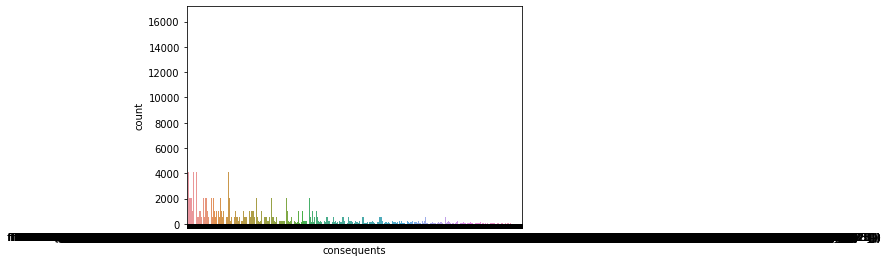

In [26]:
sns.countplot(rules['consequents'])